In [8]:
import os
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib
from tqdm import tqdm
from napatrackmater.Trackvector import (
    BROWNIAN_FEATURES
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

In [9]:
dataset_name = 'Sixth'
home_folder = '/home/debian/jz/'
channel = 'membrane_'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

normalized_dataframe = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}transferred.csv') #f'goblet_basal_dataframe_normalized_{channel}predicted_morpho_feature_attention_shallowest_litest.csv')
print(f'reading data from {normalized_dataframe}')
tracks_dataframe = pd.read_csv(normalized_dataframe)
save_dir = os.path.join(tracking_directory, f'{channel}phasespaces')
Path(save_dir).mkdir(exist_ok=True)
deltat = 10
class_map_gbr = {
        0: "Basal",
        1: "Radial",
        2: "Goblet"
    }

reading data from /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/dataframes/goblet_basal_dataframe_normalized_membrane_transferred.csv


In [3]:
all_trackmate_ids = [trackid for trackid in tracks_dataframe['TrackMate Track ID'].unique()]
result_dict = {cell_type: {} for cell_type in class_map_gbr.values()}
unique_time_points = tracks_dataframe['t'].unique()

for i, time_point in enumerate(unique_time_points - 10):
    time_data = tracks_dataframe[tracks_dataframe['t'] == time_point]
    
    if i + 1 < len(unique_time_points):
        next_time_point = unique_time_points[i + 1]
        next_time_data = tracks_dataframe[tracks_dataframe['t'] == next_time_point]

        for cell_type in class_map_gbr.values():
            cell_type_data = time_data[time_data['Cell_Type'] == cell_type]
            

            if not cell_type_data.empty:
                if time_point not in result_dict[cell_type]:
                    result_dict[cell_type][time_point] = {}
                for trackmate_id in cell_type_data['TrackMate Track ID'].unique():
                    current_trackmate_id_data = cell_type_data[cell_type_data['TrackMate Track ID'] == trackmate_id]
                    for track_id in current_trackmate_id_data['Track ID'].unique():
                        track_features = current_trackmate_id_data[current_trackmate_id_data['Track ID'] == track_id][BROWNIAN_FEATURES].to_numpy()
                        
                        if not next_time_data.empty:
                            next_cell_type_data = next_time_data[next_time_data['TrackMate Track ID'] == trackmate_id]
                            next_track_features = next_cell_type_data[next_cell_type_data['Track ID'] == track_id][BROWNIAN_FEATURES].to_numpy()
                            if next_track_features.shape[0] > 0 :
                            
                                derivative_features = next_track_features[0,:] - track_features
                            

                                for feature_name in BROWNIAN_FEATURES:
                                    pair_key = f"{feature_name}"
                                    if derivative_features.shape[0] > 0:
                                        
                                        pairwise_values = np.stack(
                                            [track_features[:, BROWNIAN_FEATURES.index(feature_name)],
                                            derivative_features[:, BROWNIAN_FEATURES.index(feature_name)]],
                                            axis=1
                                        )

                                        if pair_key not in result_dict[cell_type][time_point]:
                                            result_dict[cell_type][time_point][pair_key] = []

                                        result_dict[cell_type][time_point][pair_key].append({
                                            'Track ID': int(track_id),  
                                            'Pairwise Values': pairwise_values
                                        })


In [4]:


def build_dataframe(result_dict):
    """Converts result_dict to a pandas DataFrame for plotting, including Track ID."""
    rows = []

    for cell_type, time_data in result_dict.items():
        for time_point, feature_dict in time_data.items():
            for feature_name, track_data in feature_dict.items():
                for track_entry in track_data:
                    track_id = track_entry['Track ID']
                    pairwise_array = track_entry['Pairwise Values']

                    for feature_value, derivative_value in pairwise_array:
                        rows.append({
                            'Cell Type': cell_type,
                            'Time Point': time_point,
                            'Feature phase space': feature_name,
                            'Track ID': track_id, 
                            'Feature Value': feature_value,
                            'Derivative Value': derivative_value
                        })

    df = pd.DataFrame(rows)
    df = remove_outliers(df, ['Feature Value', 'Derivative Value'])
    return df


def remove_outliers(df, columns, lower_quantile=0.05, upper_quantile=0.99, multiplier=1.5):
    """
    Removes rows with outliers in the specified columns based on the IQR method.
    """
    for column in columns:
        q1 = df[column].quantile(lower_quantile)
        q3 = df[column].quantile(upper_quantile)
        iqr = q3 - q1
        lower_bound = q1 - multiplier * iqr
        upper_bound = q3 + multiplier * iqr

        # Filter rows within bounds
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

def plot_phasespace(df, title='phasespace',  dataset_name='dataset'):
    """Plots the phase space using seaborn's kdeplot for all time points in one plot per feature, with a color bar."""
    
    cmap = plt.cm.viridis
    norm = matplotlib.colors.Normalize(vmin=df['Time Point'].min(), vmax=df['Time Point'].max())

    for cell_type in df['Cell Type'].unique():
        cell_type_df = df[df['Cell Type'] == cell_type]
        
        for feature_name in cell_type_df['Feature phase space'].unique():
            phasespace_df = cell_type_df[cell_type_df['Feature phase space'] == feature_name]
            print(f"Plotting for {cell_type} and feature phase space {feature_name}")
            
            fig, ax = plt.subplots(figsize=(8, 10))

            for time_point in sorted(phasespace_df['Time Point'].unique()):
                time_df = phasespace_df[phasespace_df['Time Point'] == time_point]

                if len(time_df) < 2 or time_df['Feature Value'].nunique() < 2:
                    print(f"Skipping KDE for time {time_point} due to insufficient data.")
                    continue 

                color = cmap(norm(time_point))

                try:
                    sns.kdeplot(
                        data=time_df,
                        x='Feature Value',
                        y='Derivative Value',
                        label=f"Time {time_point}",
                        alpha=0.5,
                        ax=ax,
                        color=color,
                        warn_singular=False
                    )
                except ValueError as e:
                    print(f"Skipping time point {time_point} due to insufficient data for KDE plot. Error: {e}")

            ax.set_xlabel(f'{feature_name}', fontsize=14)
            ax.set_ylabel(f'{feature_name}_derivative', fontsize=14)

            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([]) 
            cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
            cbar.set_label('Time Point', fontsize=14)

            ax.set_title(f"{title} - {cell_type} ({feature_name})", fontsize=16)
            ax.legend(title="Time Points", loc="upper right", fontsize=10)

          

            plot_filename = os.path.join(save_dir, f"{title}_{cell_type}_{feature_name}_{dataset_name}_phasespace.png")
            plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()


def interactive_plot_phasespace(df, title='Phase Space'):
    """
    Creates an interactive phase space plot with a slider to control the time point displayed,
    and dropdowns to choose the cell type and feature to plot.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the data with columns:
        'Cell Type', 'Feature phase space', 'Feature Value', 'Derivative Value', 'Time Point'.
    - title (str): Title prefix for the plots.
    """
    cmap = plt.cm.viridis
    norm = matplotlib.colors.Normalize(vmin=df['Time Point'].min(), vmax=df['Time Point'].max())

    # Create dropdown for selecting Cell Type and Feature phase space
    cell_types = df['Cell Type'].unique()
    feature_names = df['Feature phase space'].unique()

    cell_type_dropdown = widgets.Dropdown(
        options=cell_types,
        description='Cell Type:',
        value=cell_types[0]
    )

    feature_dropdown = widgets.Dropdown(
        options=feature_names,
        description='Feature:',
        value=feature_names[0]
    )

    # Slider for time points
    def update_slider(*args):
        cell_type = cell_type_dropdown.value
        feature_name = feature_dropdown.value
        # Filter the DataFrame based on selected cell type and feature
        filtered_df = df[(df['Cell Type'] == cell_type) & (df['Feature phase space'] == feature_name)]
        time_points = sorted(filtered_df['Time Point'].unique())
        slider.min = time_points[0]
        slider.max = time_points[-1]
        slider.value = time_points[0]  # Reset to the first time point
    
    # Time point slider for the selected cell type and feature
    slider = widgets.IntSlider(
        value=1,
        min=0,
        max=10,
        step=1,
        description='Time Point:',
        continuous_update=False
    )

    cell_type_dropdown.observe(update_slider, names='value')
    feature_dropdown.observe(update_slider, names='value')

    # Plot update function
    def update_plot(time_point):
        clear_output(wait=True)
        display(cell_type_dropdown, feature_dropdown, slider)

        cell_type = cell_type_dropdown.value
        feature_name = feature_dropdown.value
        
        filtered_df = df[(df['Cell Type'] == cell_type) & (df['Feature phase space'] == feature_name)]
        time_df = filtered_df[filtered_df['Time Point'] == time_point]

        # Check for enough data to plot
        if len(time_df) < 2 or time_df['Feature Value'].nunique() < 2:
            print(f"Skipping KDE for time {time_point} due to insufficient data.")
            return

        # Plotting
        color = cmap(norm(time_point))
        fig, ax = plt.subplots(figsize=(8, 10))
        
        try:
            sns.kdeplot(
                data=time_df,
                x='Feature Value',
                y='Derivative Value',
                ax=ax,
                color=color,
                warn_singular=False
            )
        except ValueError as e:
            print(f"Skipping time point {time_point} due to insufficient data for KDE plot. Error: {e}")
            return

        ax.set_xlabel(f'{feature_name}', fontsize=14)
        ax.set_ylabel(f'{feature_name}_derivative', fontsize=14)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([]) 
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
        cbar.set_label('Time Point', fontsize=14)

        ax.set_title(f"{title} - {cell_type} ({feature_name}) - Time {time_point}", fontsize=16)
        plt.show()

    update_slider()
    widgets.interact(update_plot, time_point=slider)


def test_ergodicity(
    df, 
    time_delta=50, 
):
    """
    Tests ergodicity by comparing the average of time averages (tracks) with 
    the average of ensemble averages (time points) over specified time intervals.
    Saves comparison plots for each feature, iterating over all cell types.
    """
    
    os.makedirs(save_dir, exist_ok=True)  # Ensure output directory exists
    all_differences_by_cell_type = {cell_type: {} for cell_type in df['Cell Type'].unique()}

    for cell_type in df['Cell Type'].unique():
        # Iterate over all unique features in the dataframe
        for feature_name in df['Feature phase space'].unique():
            ergodicity_results = []
            differences_over_time = []
           

        
            cell_type_df = df[df['Cell Type'] == cell_type]
            total_time_points = len(cell_type_df['Time Point'].unique())
            time_points = sorted(cell_type_df['Time Point'].unique())

            for start_time in tqdm(range(0, total_time_points + 2 * time_delta, time_delta)):
                if start_time + time_delta >= total_time_points:
                    start_time = total_time_points - time_delta

                end_time = min(start_time + time_delta, total_time_points)
                time_interval_points = time_points[start_time:end_time]

                interval_df = cell_type_df[cell_type_df['Time Point'].isin(time_interval_points)]
                feature_df = interval_df[interval_df['Feature phase space'] == feature_name]

                # Time averages for each track over the interval
                track_time_averages = []
                for track_id in feature_df['Track ID'].unique():
                    track_df = feature_df[feature_df['Track ID'] == track_id]
                    time_avg_feature = np.mean(track_df['Feature Value'].values)
                    track_time_averages.append(time_avg_feature)

                # Ensemble averages for each time point in the interval
                time_point_ensemble_averages = []
                for time_point in time_interval_points:
                    time_df = feature_df[feature_df['Time Point'] == time_point]
                    ensemble_avg_feature = np.mean(time_df['Feature Value'].values)
                    time_point_ensemble_averages.append(ensemble_avg_feature)

                # Compare average of time averages with average of ensemble averages
                avg_time_avg_feature = np.mean(track_time_averages)
                avg_ensemble_avg_feature = np.mean(time_point_ensemble_averages)
                diff = abs(avg_time_avg_feature - avg_ensemble_avg_feature)
                differences_over_time.append((start_time, diff))

            

                
                ergodicity_results.append({
                    'Cell Type': cell_type,
                    'Feature': feature_name,
                    'Interval': f"{start_time}-{end_time}",
                    'Time Avg': avg_time_avg_feature,
                    'Ensemble Avg': avg_ensemble_avg_feature,
                    'Difference': diff,
                })
            all_differences_by_cell_type[cell_type][feature_name] = differences_over_time
            # Save results and plot for each feature
            if ergodicity_results:
                ergodicity_df = pd.DataFrame(ergodicity_results)
                sns.set(style="whitegrid")
                plt.figure(figsize=(10, 6))

                # Plot each cell type's results
                for cell_type in ergodicity_df['Cell Type'].unique():
                    cell_type_data = ergodicity_df[ergodicity_df['Cell Type'] == cell_type]
                    sns.lineplot(
                        data=cell_type_data, 
                        x="Interval", 
                        y="Time Avg", 
                        label=f"{cell_type} Time Avg", 
                        marker="o"
                    )
                    sns.lineplot(
                        data=cell_type_data, 
                        x="Interval", 
                        y="Ensemble Avg", 
                        label=f"{cell_type} Ensemble Avg", 
                        marker="s"
                    )

                
                
                plt.title(f"Ergodicity Test for {cell_type}_{feature_name}")
                plt.ylabel("Value")
                plt.xlabel("Time Interval")
                plt.legend()
                plt.xticks(rotation=45)
                plt.tight_layout()

                # Save plot for each feature
                plot_path = os.path.join(save_dir, f"ergodicity_{cell_type}_{feature_name}.png")
                plt.savefig(plot_path)
                plt.show()
                plt.close()
                print(f"Saved plot for {feature_name} at {plot_path}")
            else:
                print(f"No ergodic intervals detected for feature {cell_type}_{feature_name}.")

    for cell_type, features in all_differences_by_cell_type.items():
            plt.figure(figsize=(12, 6))
            
            # Plot the difference for each feature in the current cell type
            for feature_name, differences in features.items():
                times, diffs = zip(*differences)  # Unzip the list of tuples
                sns.lineplot(x=times, y=diffs, label=feature_name)

            plt.title(f"Ergodicity Test Differences for {cell_type}")
            plt.xlabel("Time Interval")
            plt.ylabel("Difference (Time Avg - Ensemble Avg)")
            plt.legend(title="Features")
            plt.grid(True)
            plt.tight_layout()
            
            # Save the plot for the current cell type
            plot_path = os.path.join(save_dir, f"ergodicity_differences_{cell_type}.png")
            plt.savefig(plot_path)
            plt.show()
            plt.close()
            print(f"Saved plot for {cell_type} at {plot_path}")    


            

In [5]:
feature_dataframe = build_dataframe(result_dict)


100%|██████████| 16/16 [00:28<00:00,  1.79s/it]


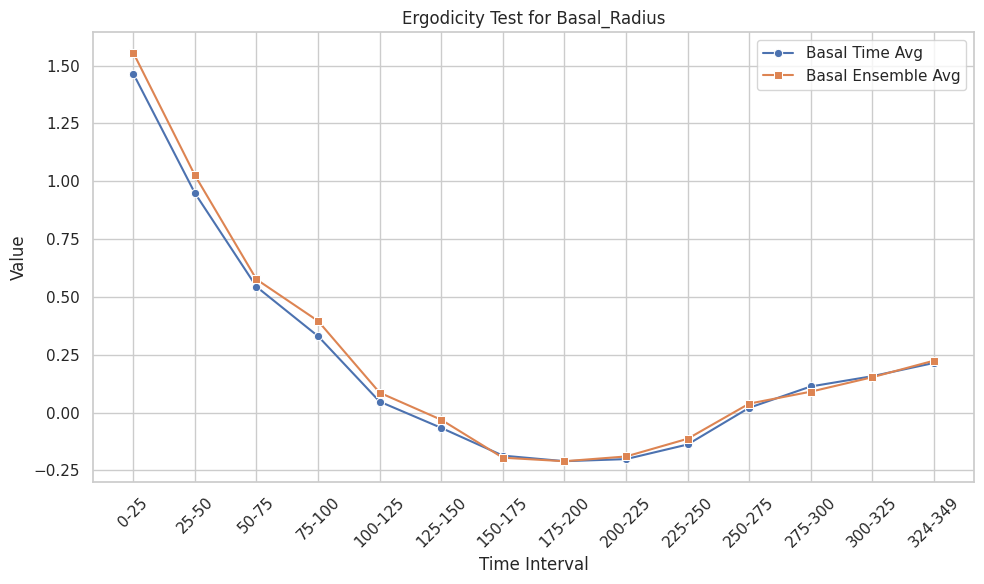

Saved plot for Radius at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Basal_Radius.png


100%|██████████| 16/16 [00:28<00:00,  1.76s/it]


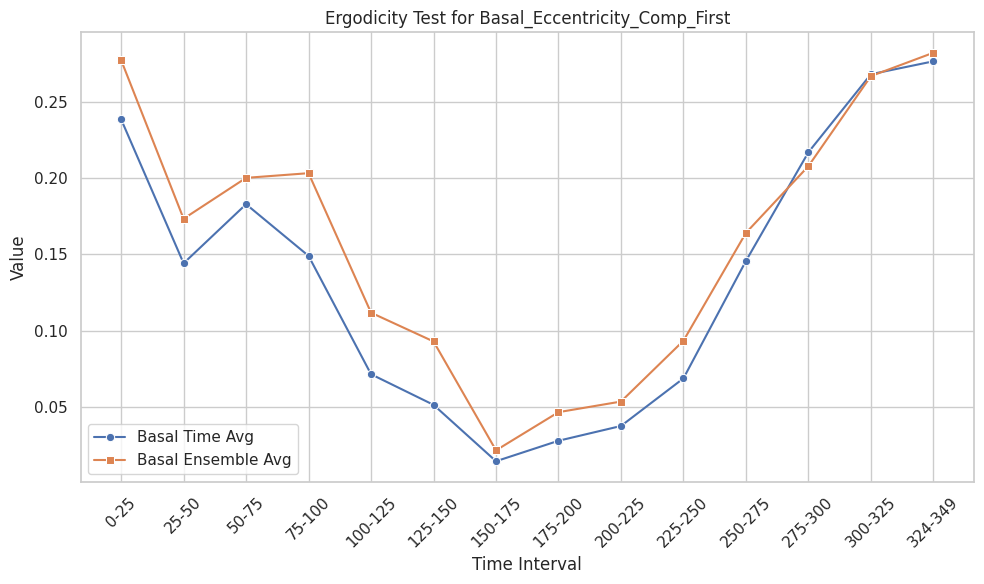

Saved plot for Eccentricity_Comp_First at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Basal_Eccentricity_Comp_First.png


100%|██████████| 16/16 [00:28<00:00,  1.79s/it]


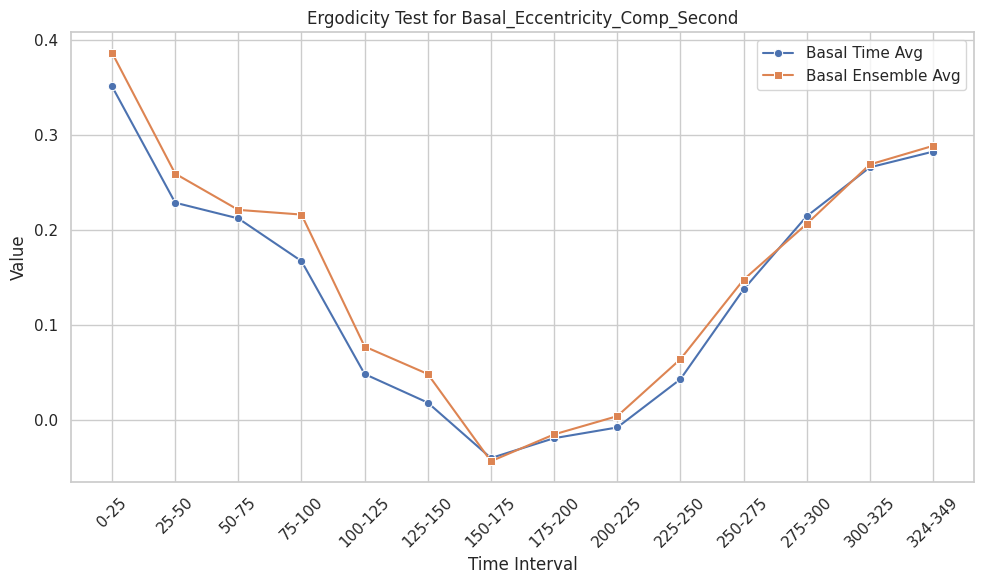

Saved plot for Eccentricity_Comp_Second at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Basal_Eccentricity_Comp_Second.png


100%|██████████| 16/16 [00:28<00:00,  1.80s/it]


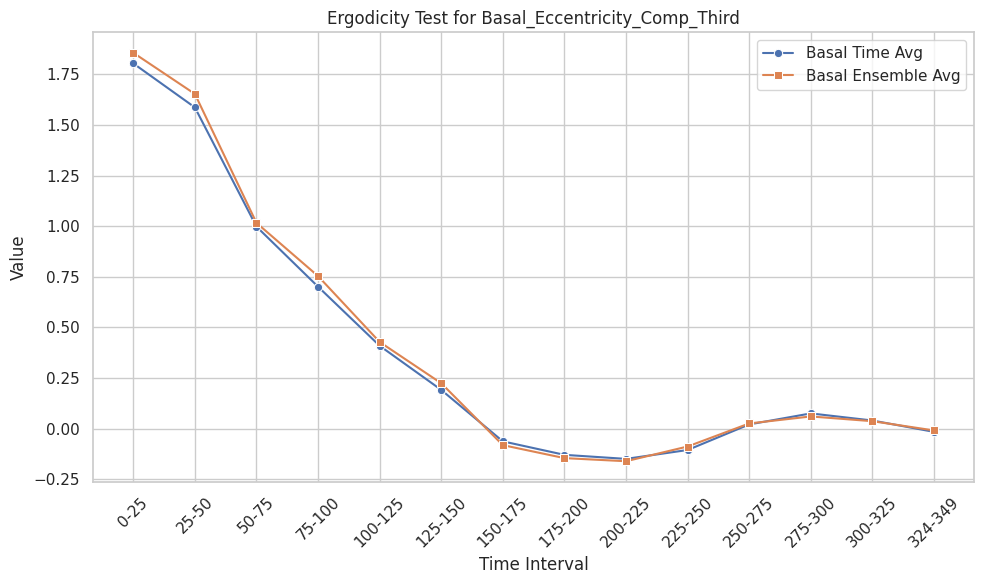

Saved plot for Eccentricity_Comp_Third at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Basal_Eccentricity_Comp_Third.png


100%|██████████| 16/16 [00:30<00:00,  1.88s/it]


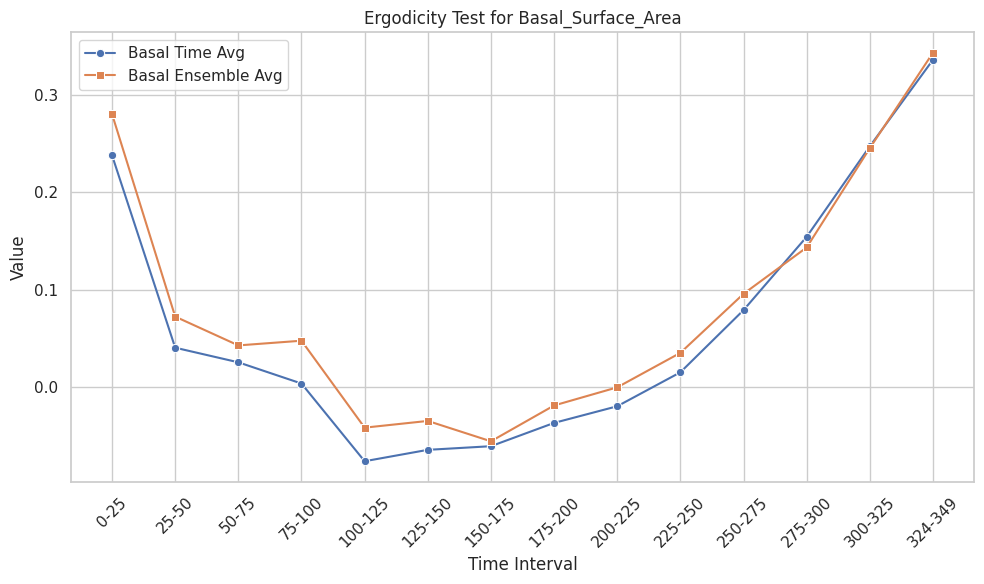

Saved plot for Surface_Area at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Basal_Surface_Area.png


100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


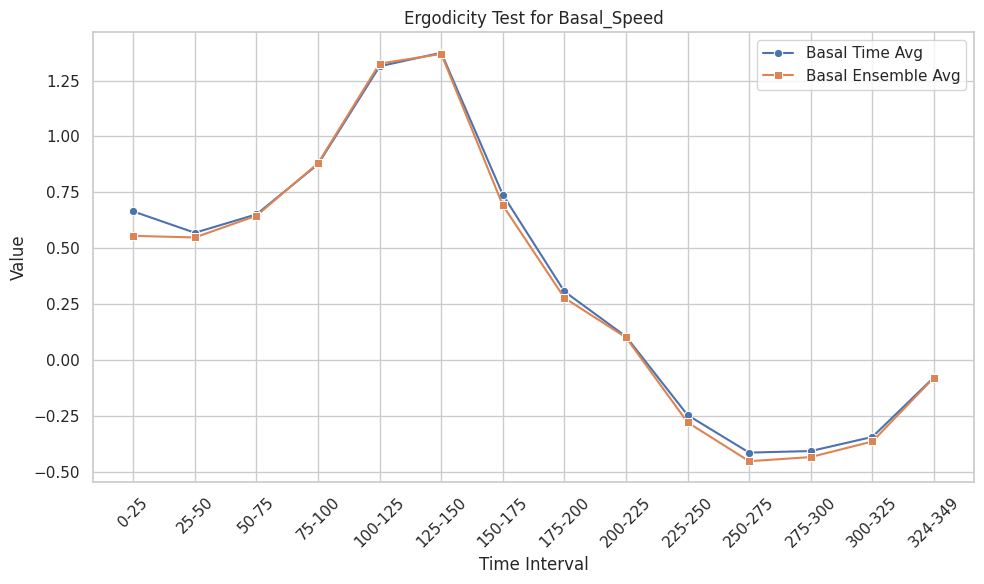

Saved plot for Speed at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Basal_Speed.png


100%|██████████| 16/16 [00:28<00:00,  1.76s/it]


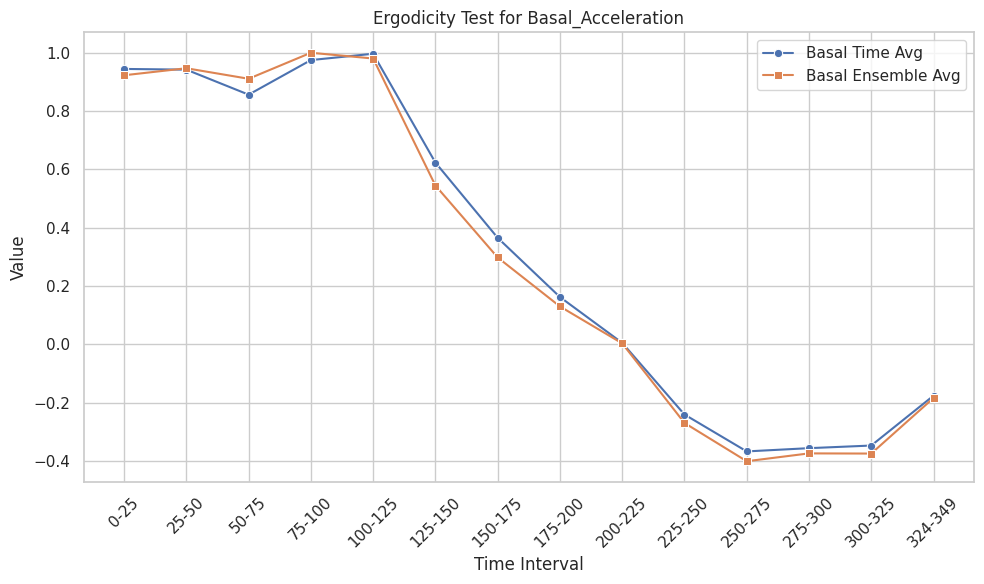

Saved plot for Acceleration at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Basal_Acceleration.png


100%|██████████| 16/16 [00:00<00:00, 26.17it/s]


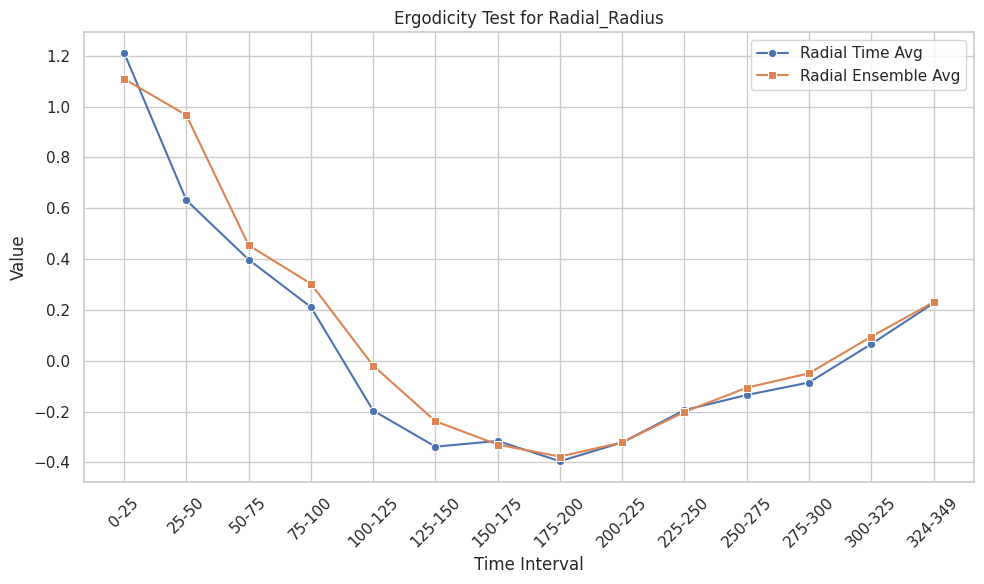

Saved plot for Radius at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Radial_Radius.png


100%|██████████| 16/16 [00:00<00:00, 28.00it/s]


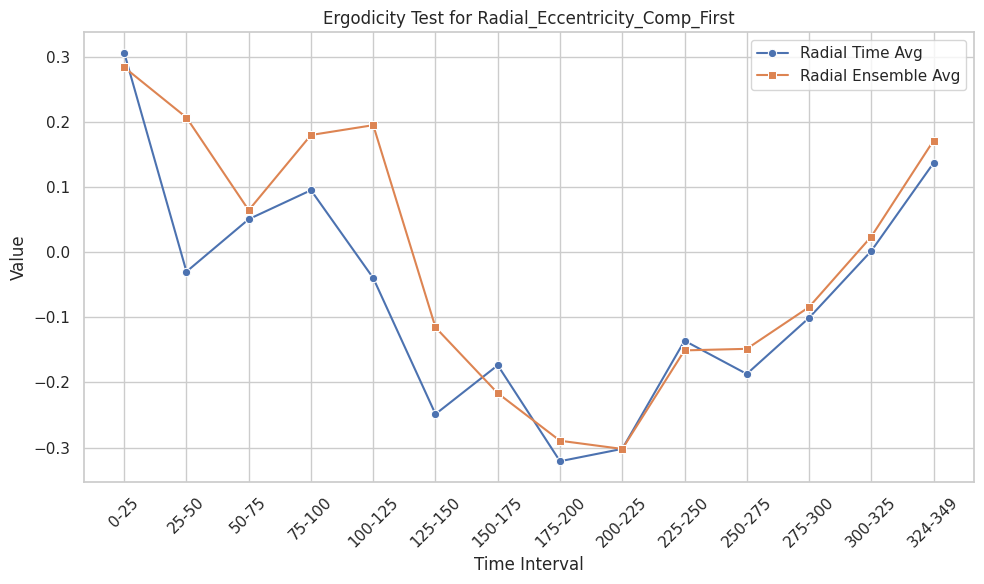

Saved plot for Eccentricity_Comp_First at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Radial_Eccentricity_Comp_First.png


100%|██████████| 16/16 [00:00<00:00, 27.00it/s]


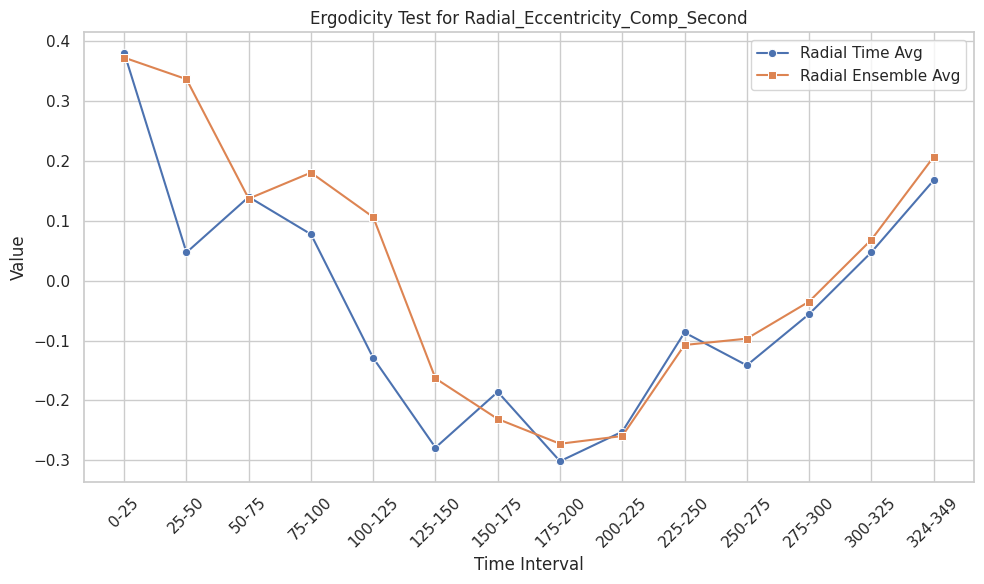

Saved plot for Eccentricity_Comp_Second at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Radial_Eccentricity_Comp_Second.png


100%|██████████| 16/16 [00:00<00:00, 26.44it/s]


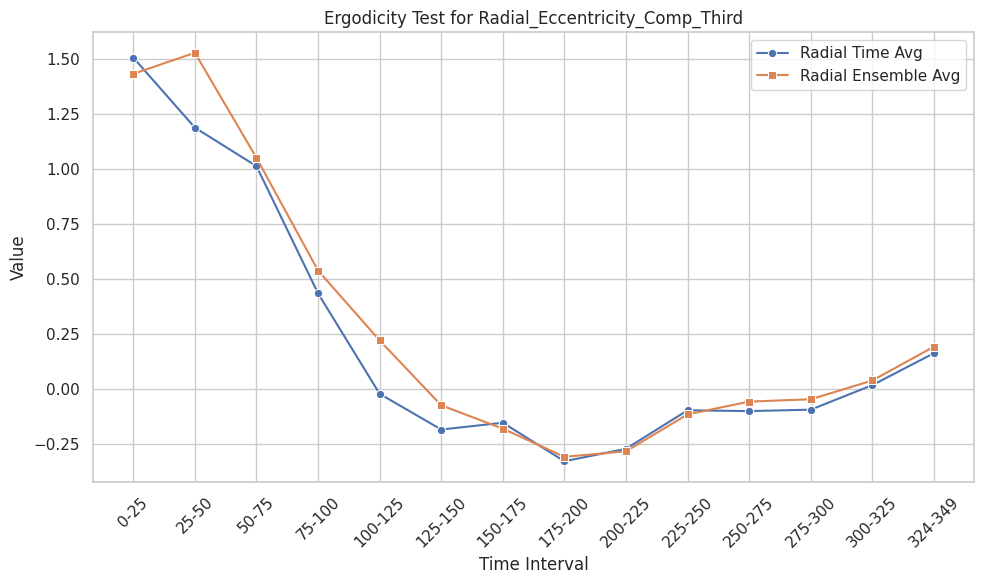

Saved plot for Eccentricity_Comp_Third at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Radial_Eccentricity_Comp_Third.png


100%|██████████| 16/16 [00:00<00:00, 26.62it/s]


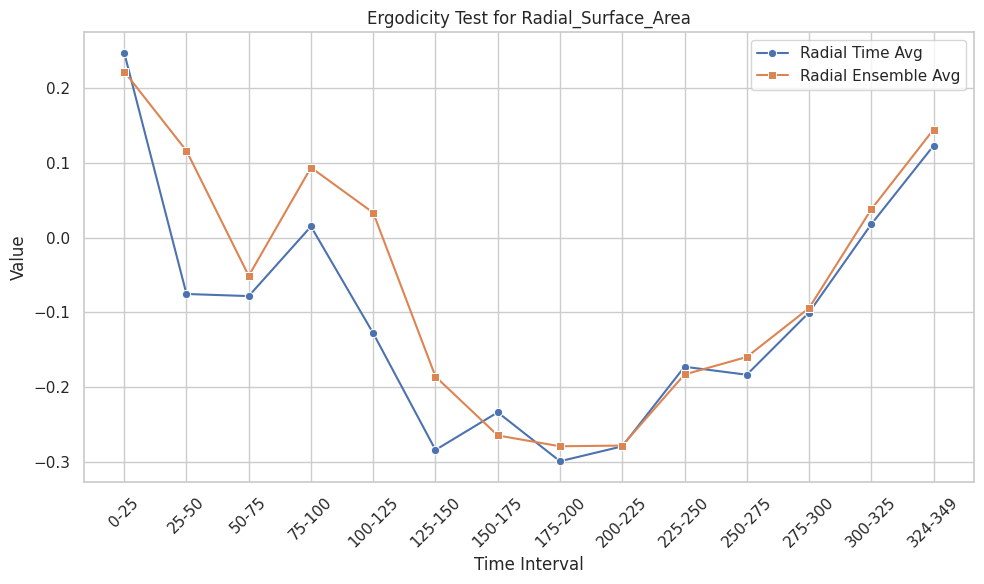

Saved plot for Surface_Area at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Radial_Surface_Area.png


100%|██████████| 16/16 [00:00<00:00, 27.61it/s]


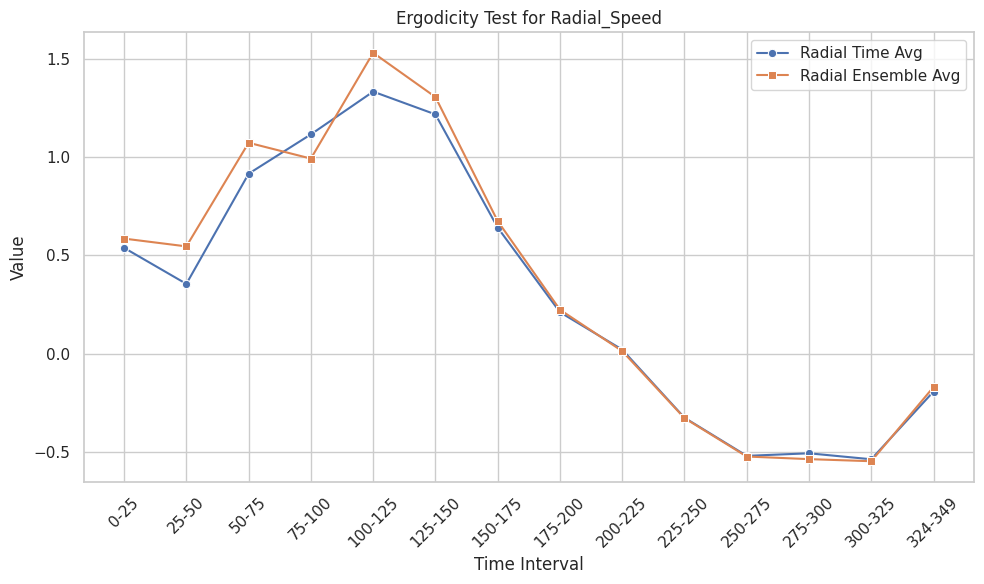

Saved plot for Speed at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Radial_Speed.png


100%|██████████| 16/16 [00:00<00:00, 25.86it/s]


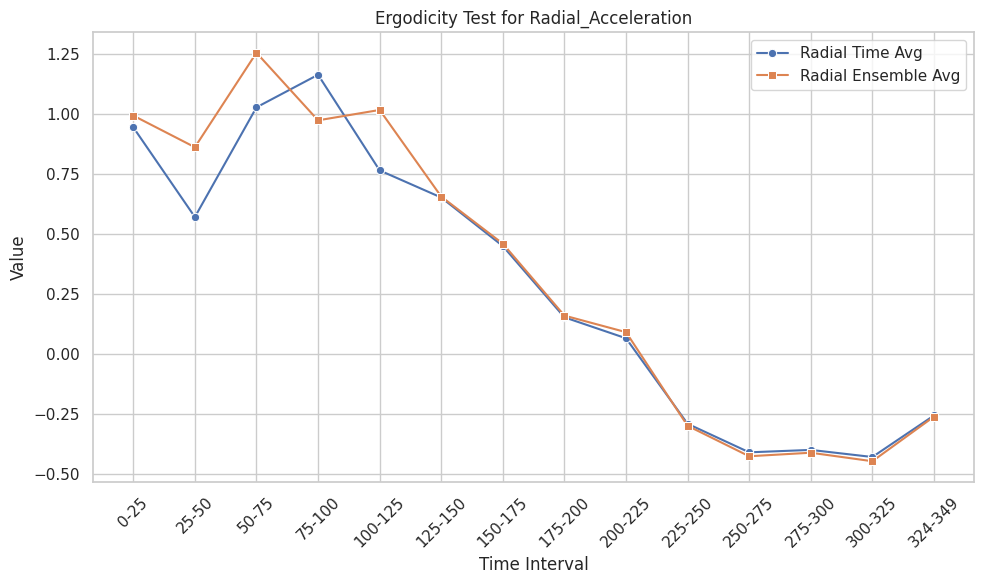

Saved plot for Acceleration at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Radial_Acceleration.png


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


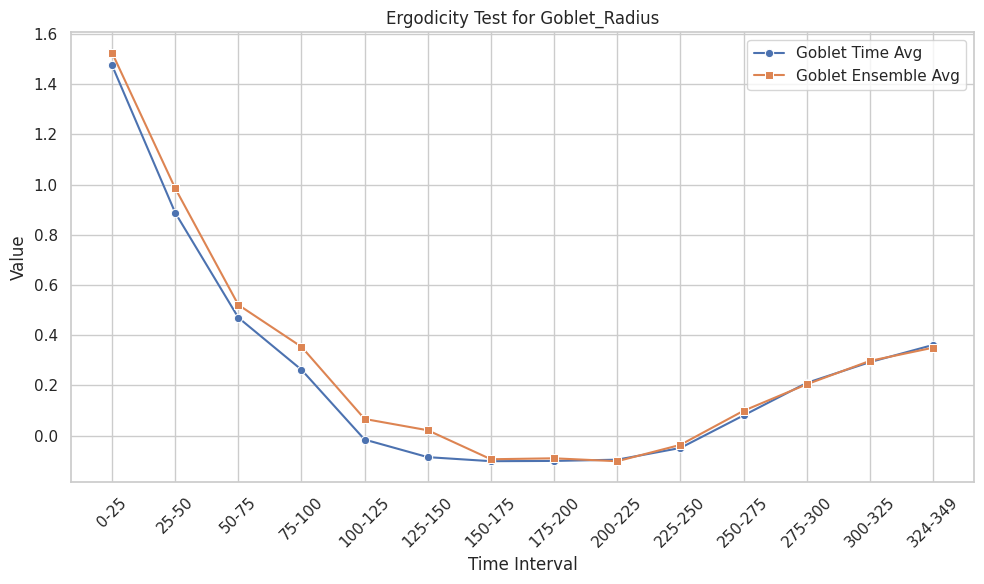

Saved plot for Radius at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Goblet_Radius.png


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


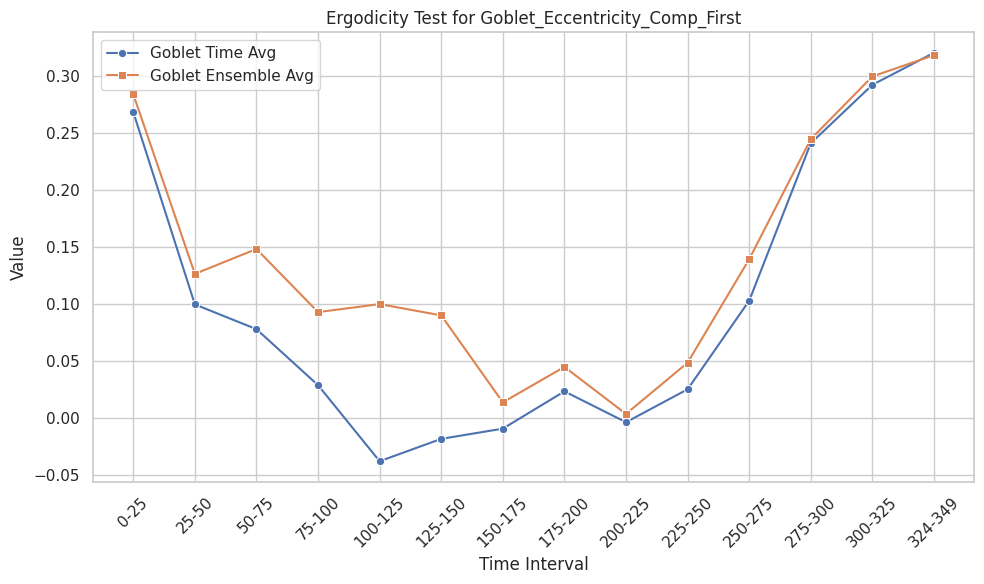

Saved plot for Eccentricity_Comp_First at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Goblet_Eccentricity_Comp_First.png


100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


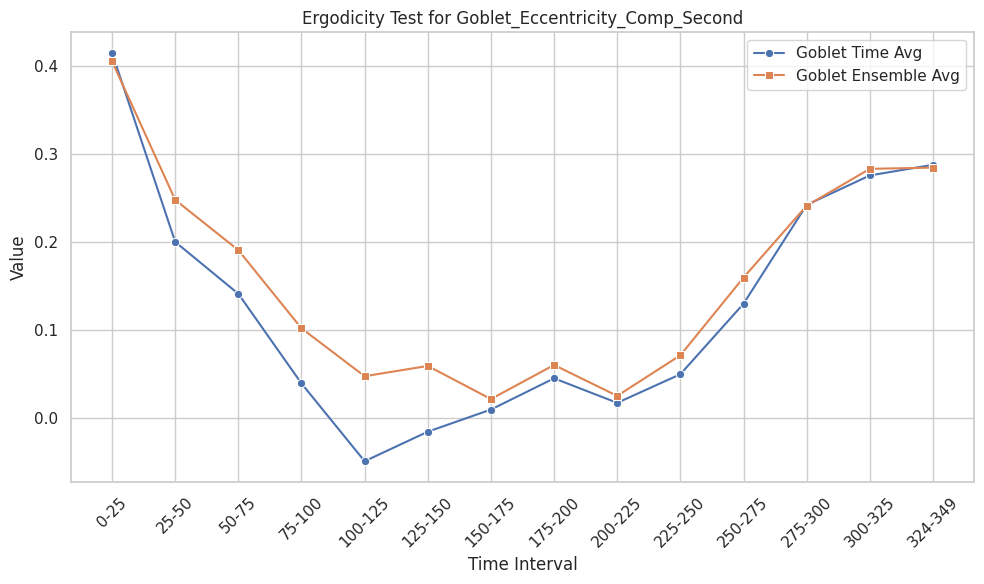

Saved plot for Eccentricity_Comp_Second at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Goblet_Eccentricity_Comp_Second.png


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


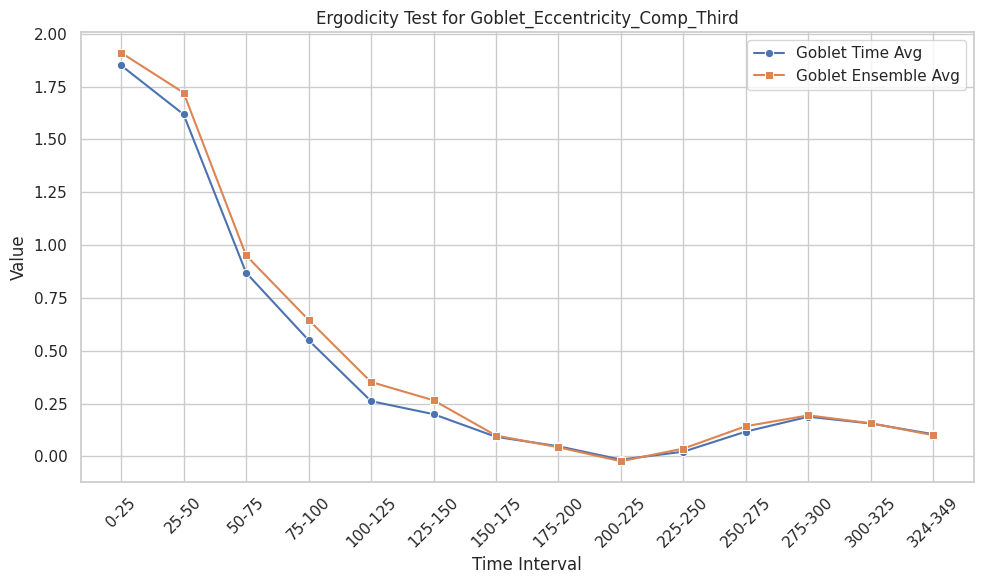

Saved plot for Eccentricity_Comp_Third at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Goblet_Eccentricity_Comp_Third.png


100%|██████████| 16/16 [00:04<00:00,  3.58it/s]


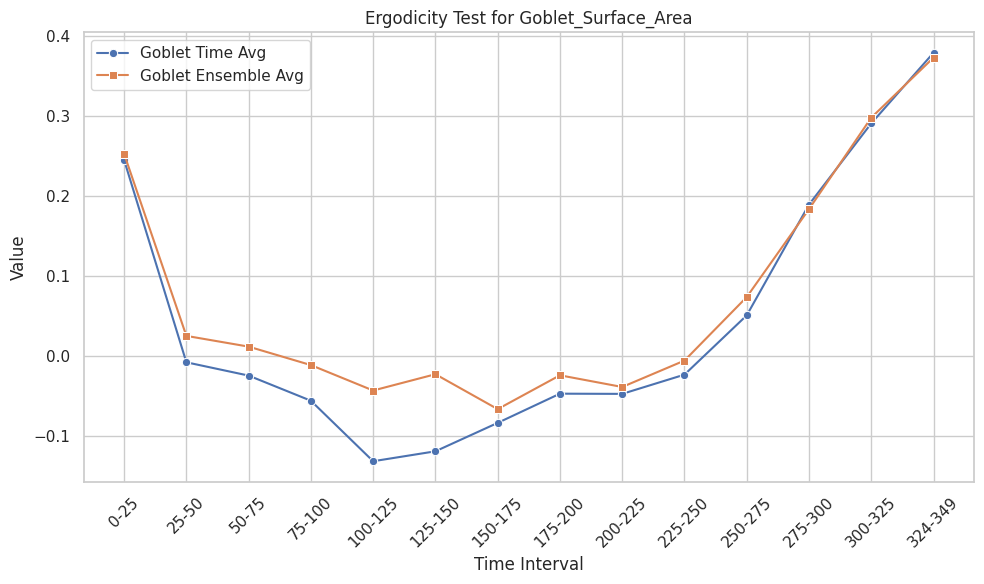

Saved plot for Surface_Area at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Goblet_Surface_Area.png


100%|██████████| 16/16 [00:04<00:00,  3.64it/s]


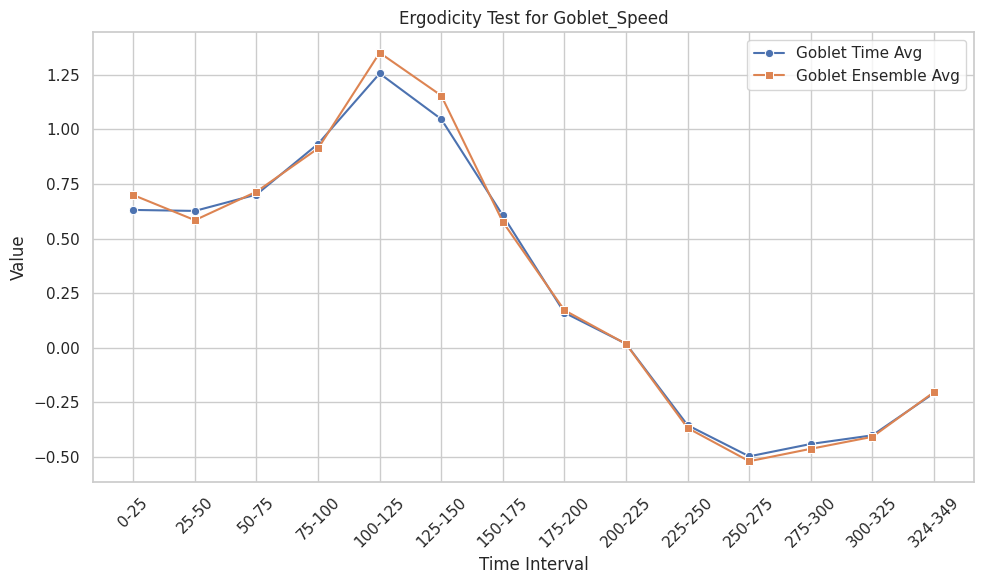

Saved plot for Speed at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Goblet_Speed.png


100%|██████████| 16/16 [00:04<00:00,  3.57it/s]


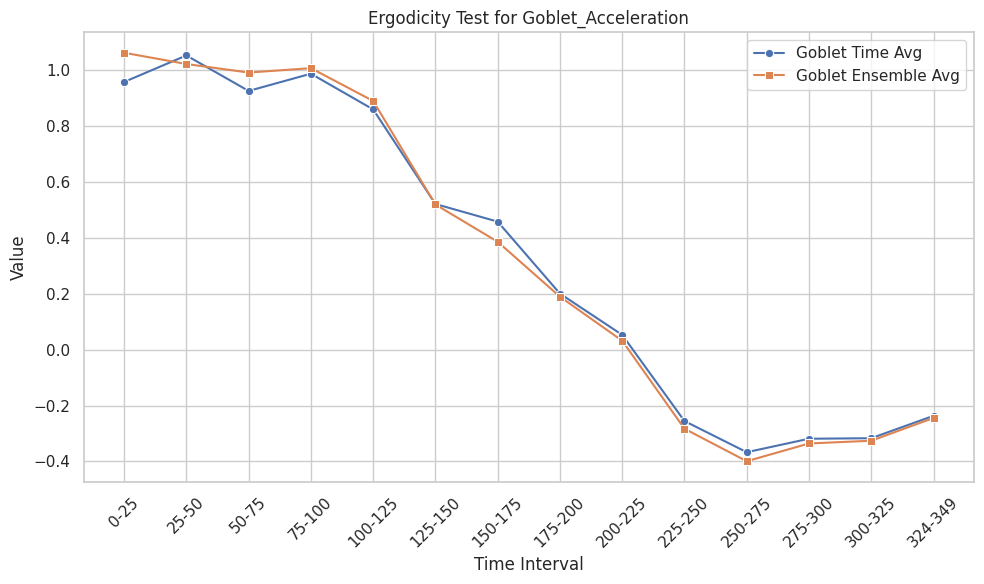

Saved plot for Acceleration at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_Goblet_Acceleration.png


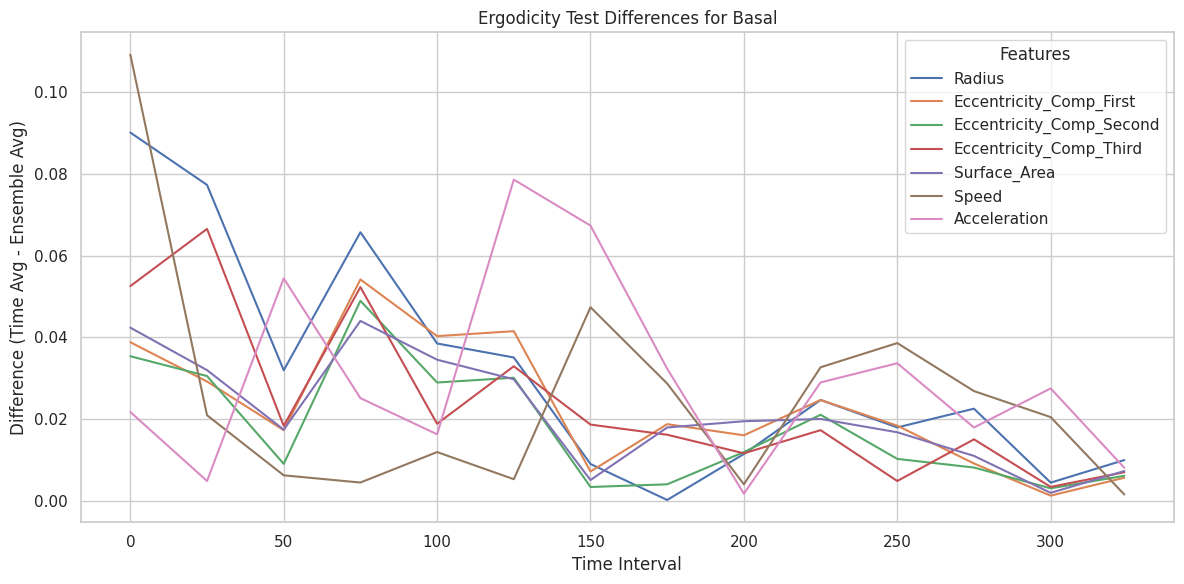

Saved plot for Basal at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_differences_Basal.png


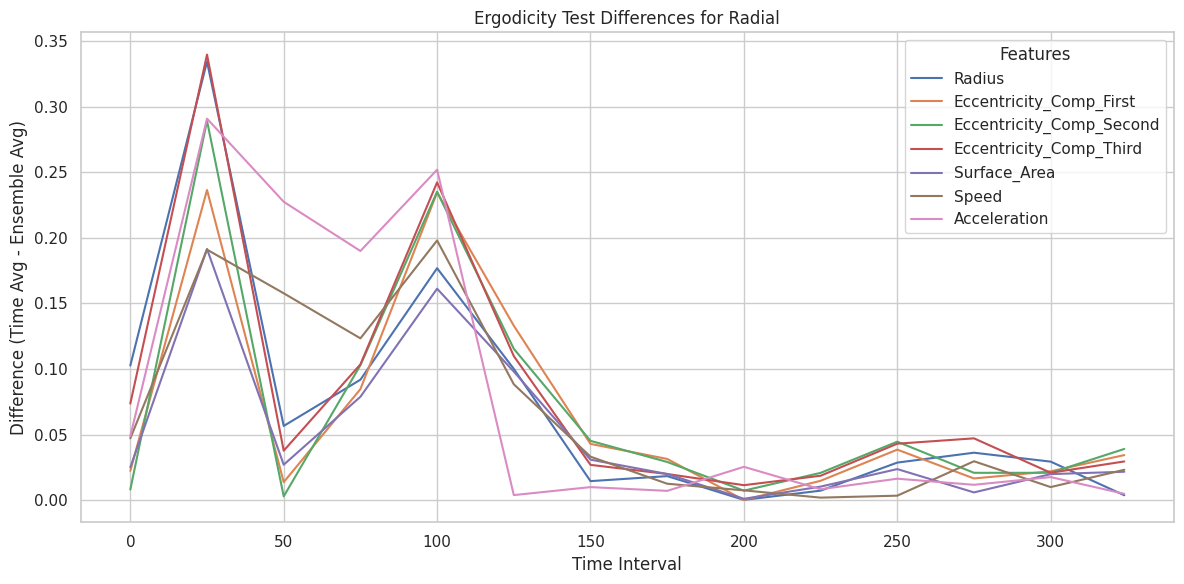

Saved plot for Radial at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_differences_Radial.png


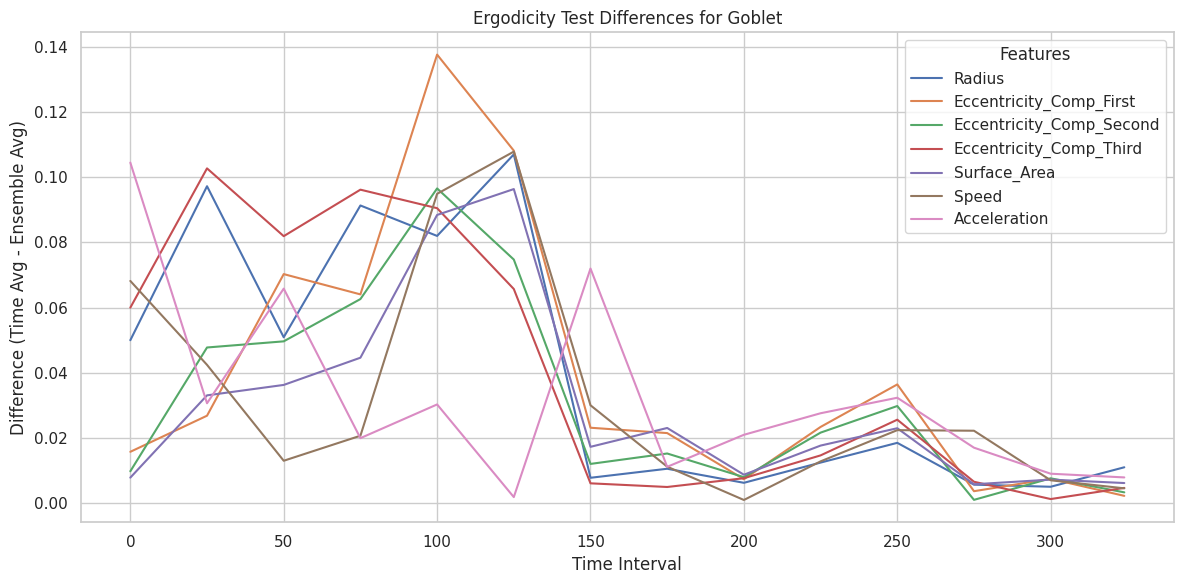

Saved plot for Goblet at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/membrane_phasespaces/ergodicity_differences_Goblet.png


In [6]:
test_ergodicity(feature_dataframe, time_delta=25)

In [ ]:

plot_phasespace(feature_dataframe)

In [7]:
interactive_plot_phasespace(feature_dataframe)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Time Point:', max=348), Output(…